# Bloque 2: Modelamiento de series de tiempo

Melanie Oyarzún W. (moyarzunw@udd.cl)


**Resultado de aprendizaje esperado:**

Identificar datos de series temporales, sus particularidades y riesgos, en el contexto de posibles aplicaciones profesionales en modelos predictivos.
Estimar modelos (S)ARIMA, darle un uso predictivo y comparar alternativas.

**Bibliografía recomendada:**

Stock & Watson, C.14 [link](https://www.dropbox.com/s/d09qcat340jy5q2/stock%20y%20watson%20-%20Introduccion%20a%20la%20Econometria.pdf?dl=0) ; Wooldridge, c.12 [link](https://www.dropbox.com/s/wrh0tuna27qp747/Wooldridge__Introductory_Econometrics_2nd_Ed_Solutions.pdf?dl=0), Gujarati, c.12  [link](https://www.dropbox.com/s/rrvth8vsa1c5gts/Gujarati-cap%2012.pdf?dl=0)

**Material de apoyo**

El taller cuenta con un repositorio  [https://github.com/melanieoyarzun/taller_seriestiempo_IDS](https://github.com/melanieoyarzun/taller_seriestiempo_IDS) en el cual está dispoinible todo el material.


In [302]:
# Paquetes y settings

from dateutil.parser import parse 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
#import watermark #para que puedan ver que paquetes tengo instalados, no es necesario que lo usen


import sklearn
from sklearn.linear_model import LinearRegression

import scipy
from scipy import stats

import statsmodels
import statsmodels.api as sm

%matplotlib inline
#%load_ext watermark

# setting de graficos

plt.figure(figsize=(8,5), dpi= 300, facecolor='w', edgecolor='k')



<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

In [303]:
# No correr esta celda, espara informar mis paquetes
%watermark -n -v -m -g -iv 

UsageError: Line magic function `%watermark` not found.


# Supuestos no cumplidos y opciones


Para poder interpretar causalmente un modelo de regresión lineal multiple en series de tiempo necesitamos que se cumplan los siguientes supuestos de Gauss Markov:

1. Modelo lineal en parámetros
$$y_{t}=\beta_{0}+\beta_{1}x_{1t}+\dots+\beta_{1}x_{kt}+u_{t}$$

2. Media condicionada nula o exogeneidad (que ahora es estricta)
$$ E[u_{t}|X_{js}]=0 \quad \forall s$$
3. No hay colinealidad perfecta.
4.  Homoscedasticidad
$$ Var[u_{t}|X_{js}]=\sigma \quad \forall s $$

5. No hay correlación serial.
$$ Cov[u_{t}, u_{s}|X_{js}]=\sigma \quad \forall s\ne t$$

Cada uno de estos supuestos tiene diferentes implicancias:

1-3 es que el estimador de MCO $\hat{\beta}$ es insesgado.
4-5 que tiene minima varianza de los estimadores lineales (eficiente)

1-5 -> MELI

Vemos que hay dos elementos diferentes a corte transversal: cambia la exogeneidad a uno más estricto y aparece un nuevo supuesto, correlación serial. 


# Objetivos diferentes de los modelos

Los modelos de regresión se pueden usar con dos objetivos principales: predicción y explicación.  En este bloque nos enfocaremos en la primera aplicación.

Un modelo de regresión puede ser útil para la predicción, aún cuando ninguno de sus coeficientes tenga interpretación causal. 

Desde el punto de vista de la predicción, lo que es importante es que el modelo entregue una predicción lo más precisa posible. 

La idea base es aprovechar las peculiaridades de las series temporales: la dependencia temporal y tendencias, para identificar patrones en la data que enriquezcan la predicción aun cuando no tengan valor explicativo. Estos elementos los incluiremos DENTRO de la regresión, para que represente de mejor manera el fenómeno a predecir.


# Patrones de dependencia intertemporal

¿Cuándo falla supuesto de exogeneidad estricta?

Cuando tenemos **particularidades temporales** actuando en el proceso estocástico, consecuencia de su naturaleza:

* Efecto rezagado (variable independiente rezagada)
* Retroalimentación entre variables
* Auto-dependencia, la variable depende de si misma en el pasado (variable dependiente rezagada, AR(1) )



¿Cómo identificar estos problemas?

1. Debemos pensar en el tipo de datos que deseo analizar (macroeconomico, acciones, ventas, etc) y posibles dinamicas en el tiempo que podrían estar presentes.
2. Chequeamos grafica y estadísticamente:
- Estacionareidad
- Presencia de ciclos
- Presencia de quiebres estructurales

3. Sobre la serie desetacionarizada, estimamos modelos.

## Estacionareidad

Entenderemos estacionareidad si el futuro se parece al pasado, al menos en un sentido probabilistico.



Una serie es estacionaria si:

1. Su distribución de probabilidad no varia en el tiempo, 
2. Su media, varianza y covarianza es constante

### Ejemplo


Hay muchos ejemplos de tipos de no estacionareidad. Ilustremos los más tipicos con unos ejemplos ficticios.

In [304]:
x = np.linspace(0, np.pi*10, 360)
y = np.sin(x)

Podemos generar los diferentes tipos con algunas manipulaciones algebráicas.

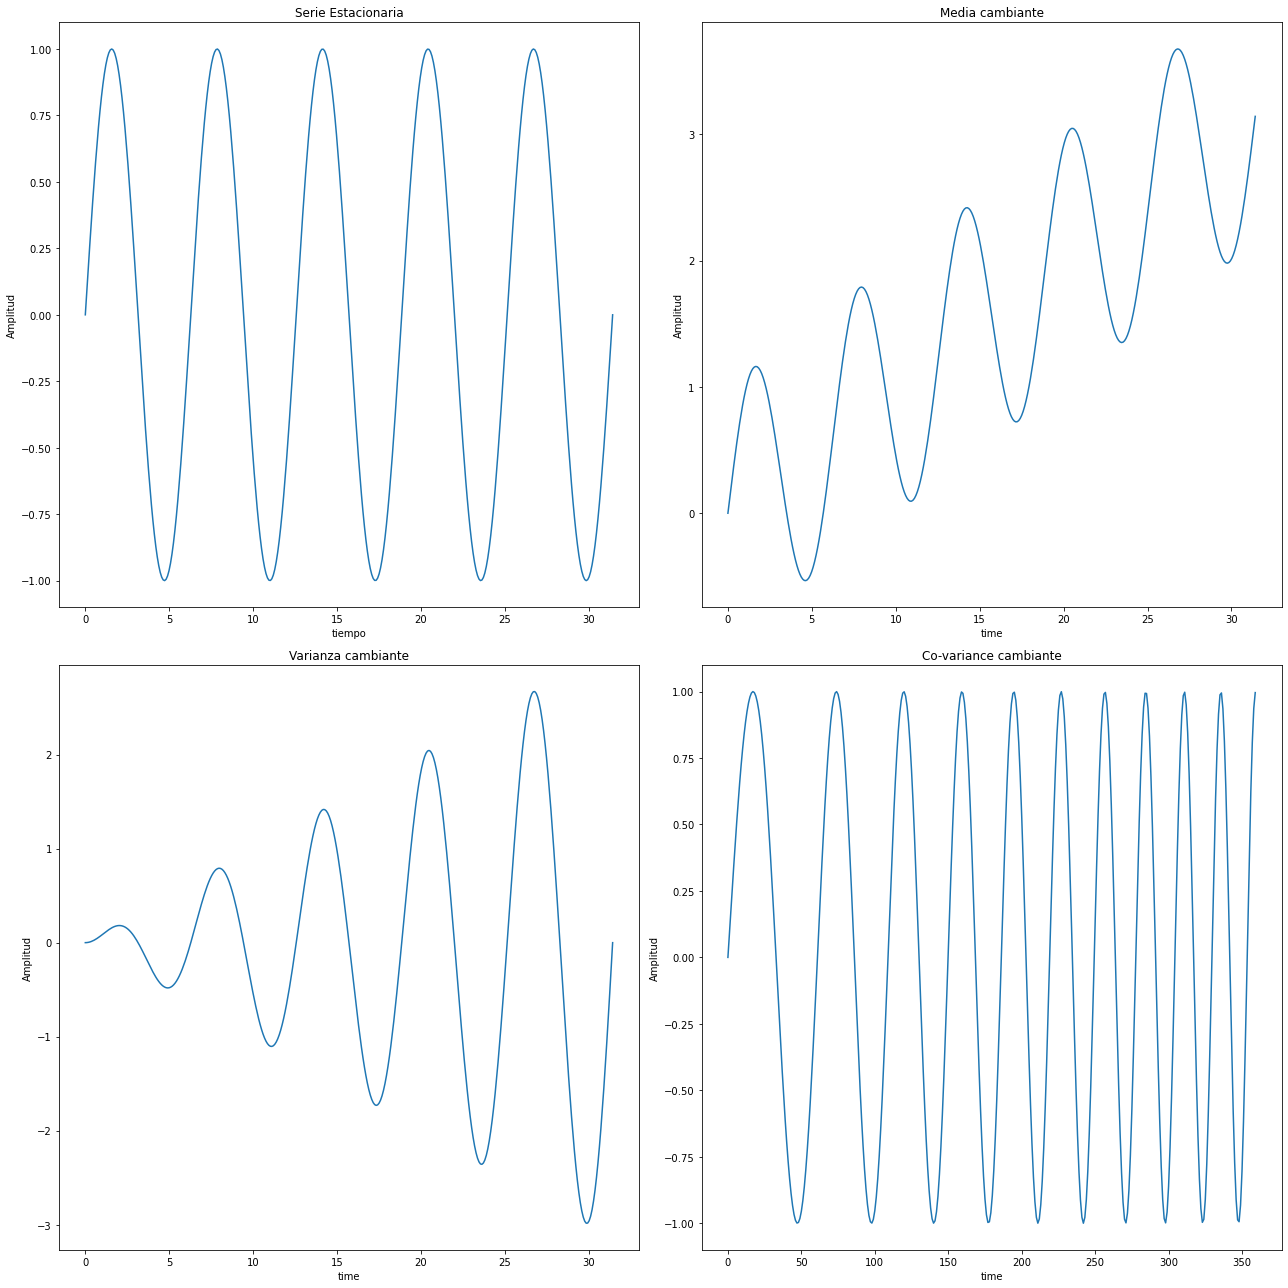

In [305]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
axs[0][0].plot(x, y)
axs[0][0].set_title('Serie Estacionaria')
axs[0][0].set_xlabel('tiempo')
axs[0][0].set_ylabel('Amplitud')

axs[0][1].plot(x, y+x/10)
axs[0][1].set_title('Media cambiante')
axs[0][1].set_xlabel('time')
axs[0][1].set_ylabel('Amplitud')


axs[1][0].plot(x, y*x/10)
axs[1][0].set_title('Varianza cambiante')
axs[1][0].set_xlabel('time')
axs[1][0].set_ylabel('Amplitud')

axs[1][1].plot(np.sin(x+x*x/30))
axs[1][1].set_title('Co-variance cambiante')
axs[1][1].set_xlabel('time')
axs[1][1].set_ylabel('Amplitud')

plt.tight_layout()

### Ausencia de estacionareidad 1: Tendencias

Un claro ejemplo de series no estacionarias es cuando hay tendencias. Podemos identificar la tendencia a tarvés de una **media movil**
Revisemoslo con los datos de pasajeros de aerolineas.

In [306]:
# Cargar datos

airline = pd.read_csv('data/international-airline-passengers.csv', sep=';')

# Nota: si no les reconoce bien la dependencia de la carpeta, pueden usar también
#airline= pd.read_csv("https://github.com/melanieoyarzun/taller_seriestiempo_IDS/blob/8c0b9774be8d4103da3801d3069d82b4fe006461/Data/international-airline-passengers.csv?raw=true", sep=';')


airline['Month'] = pd.to_datetime(airline['Month']+'-01')
airline.set_index('Month', inplace=True)

Con un grafico rápido, identificamos que etsá todo bien y que efectivamente se observa que la serie no es estacionaria.

Text(0, 0.5, 'Pasajeros')

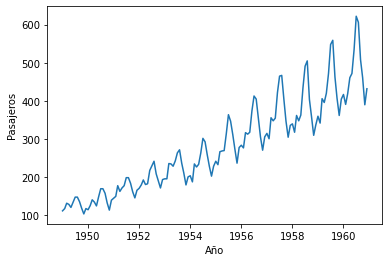

In [307]:
fig, ax = plt.subplots(1, 1)
ax.plot(airline.index, airline['Passengers'])
ax.set_xlabel('Año')
ax.set_ylabel('Pasajeros')

Podemos identificar la tendencia en los datos, al calcular la media movil.

In [308]:
def running_average(x, order):
    current = x[:order].sum()
    running = []
    
    for i in range(order, x.shape[0]):
        current += x[i]
        current -= x[i-order]
        running.append(current/order)
    
    return np.array(running)

Esta función es autoexplicativa. Simplemente corre en el dataset paso a paso y calcula la media en una ventana específica. Ahora podemos agregar esta línea de tendencia al gráfico anterior.

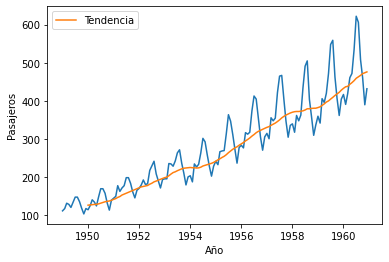

In [309]:
trend = running_average(airline['Passengers'], 12)

fig, ax = plt.subplots(1, 1)
ax.plot(airline.index, airline['Passengers'])
ax.set_xlabel('Año')
ax.set_ylabel('Pasajeros')
ax.plot(airline.index[12:], trend, label='Tendencia')
ax.legend()

A la serie, entonces, le podemos sacar esta tendencia, al dividr.

In [310]:
detrended = airline.iloc[12:].values.flatten()/trend

Y graficamente:

Text(0, 0.5, 'Detrended value')

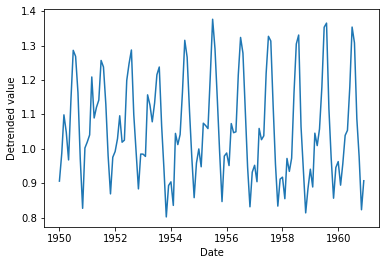

In [311]:
fig, ax = plt.subplots(1, 1)
ax.plot(airline.index[12:], detrended)
ax.set_xlabel('Date')
ax.set_ylabel('Detrended value')

### Ausencia de estacionareidad 2: Estacionalidad (no confundir con estacionareidad)

Es cuando hay un patron claro de ciclos que se repite en el tiempo. Generalmente los identificamos a priori con una inspección del grafico. Podemos usar una función para identificarlos. 

In [312]:
def plot_seasons(detrended, order, plot_mean = True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    N = len(detrended)

    data = np.array([detrended[i::order] for i in range(order)])
    
    means = np.mean(data, axis=1)
    medians = np.median(data, axis=1)
    
    counts = [0]
    counts.extend([len(data[i]) for i in range(order)])
    counts = np.cumsum(counts)

    ticks = (counts[:-1]+counts[1]/2)
    
    for i in range(order):
        values = data[i, :]
        npoints = len(values)

        plt.plot(range(counts[i], counts[i+1]), values, c=colors[0])
        plt.plot(range(counts[i], counts[i+1]), np.ones(npoints)*means[i], c=colors[1])
        plt.plot(range(counts[i], counts[i+1]), np.ones(npoints)*medians[i], c=colors[2])

    plt.legend(['data', 'mean', 'median'])
    plt.xlabel('season')
    plt.ylabel('values')
    plt.xticks(ticks, np.arange(order));
    
    if plot_mean:
        plt.plot(ticks, means, c=colors[3])
    
    return means

Acá, simplemente vamos a graficar la curva para diferentes periodos en la temporada. Esto se hace yendo a traves del dataset con un stride igual al periodo estacional.

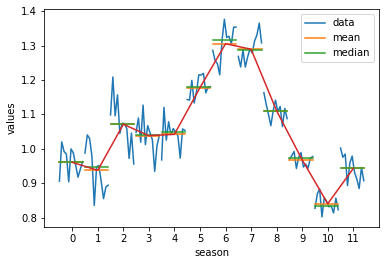

In [313]:
means = plot_seasons(detrended, 12)

La figura tambien nos provee una forma arquetípica de comportamiento estacional. COn esto, podememos terminar la descomposición de la data en tres componentes.

In [314]:
# Descomposición multiplicativa
def decomposition(data, order, plot=True):
    values = data.values.flatten()
    trend = running_average(values, order)
    detrended = values[order:]/trend
    
    season = [detrended[i::order].mean() for i in range(order)]
    seasonality = np.array(season*(detrended.shape[0]//order+1))[:detrended.shape[0]]
    residuals = values[order:]/(trend*seasonality)

    if plot:
        fig, axs = plt.subplots(4, 1, figsize=(22, 16), sharex=True)
        index = data.index

        axs[0].plot(index, values)
        axs[0].set_title('Data original')
        
        axs[1].plot(index[order:], trend)
        axs[1].set_title('Tendencia')

        axs[2].plot(index[order:], detrended)
        axs[2].set_title('Estacionalidad')

        axs[3].plot(index[order:], residuals)
        axs[3].set_title('Residuos')
        
    return values, trend, seasonality, residuals

Con esto , el patron estacional se remueve al repetir el patron medio estacional identificado anteriormente y dividiendo, desde la data sin tendencia. El resultado de esta disvision son simpemente los residuos. Lo que nos muestra que esta descomposición es demasiado sencilla aun.

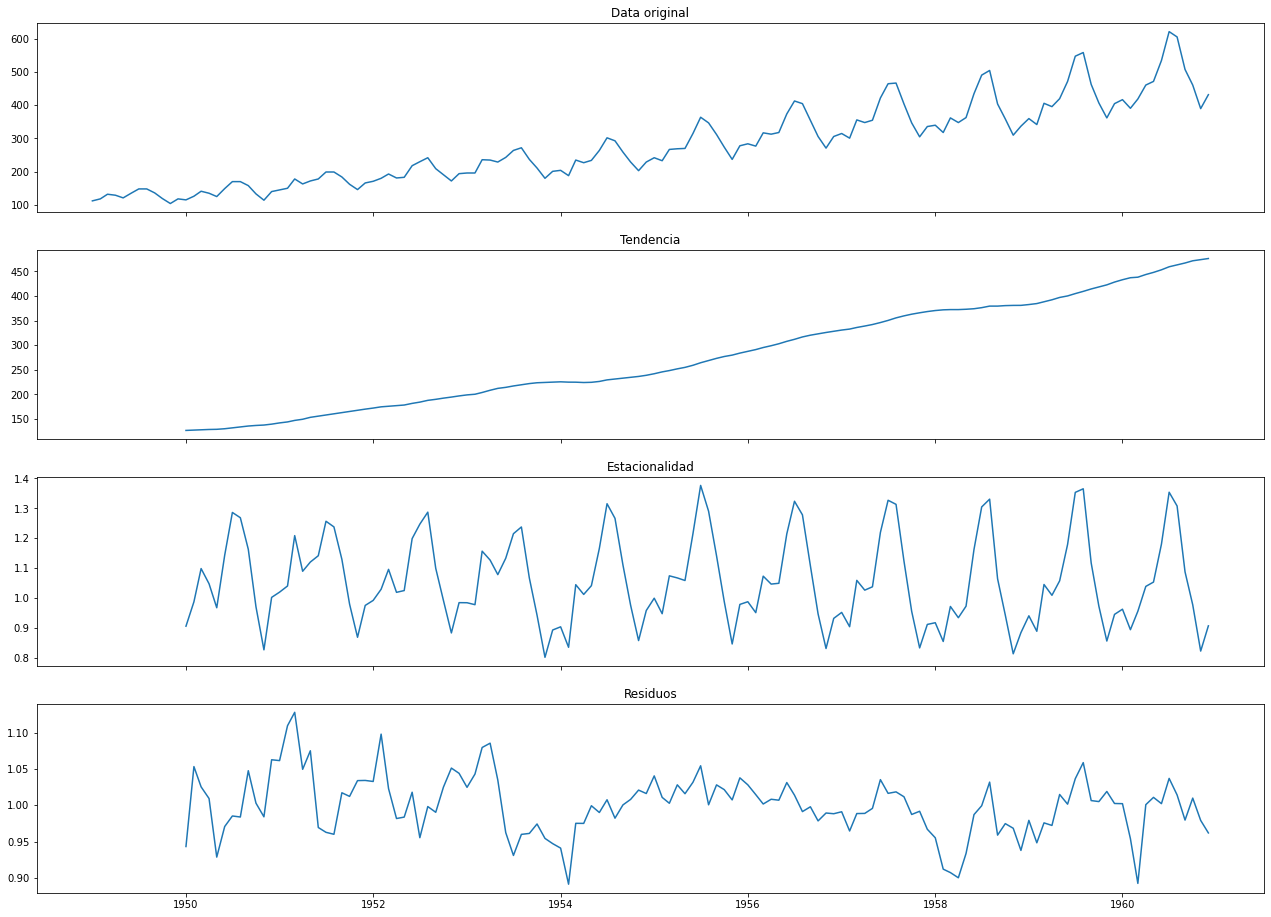

In [315]:
values, trend, seasonality, residuals = decomposition(airline, 12)

Acá usamos una descomposición multiplicativa, pero este mismo proneso se podría haber hecho siguiendo una descomposición aditiva, con pequeños cambios al codigo.

### Ausencia de estacionareidad 3: Quiebre estructural

Otro tipo de no estacionaeridad se presenta cuando la función de regresión poblacional cambia en el transcurso de la las observaciones. Esto puede ocurrir por varios motivos, por ejemplo cambios en una politica económica, cambios en la estructura de la economía, un nuevo invento o disrupción tecnológica, etc.


Si ocurren tales "cambios estructurales" o "rupturas", entonces un modelo de regresión que no tenga en cuenta esos cambios puede proporcionar una base engañosa para la inferencia ya la predicción.

Las estrategias para identificar un cambio estructurale son varias revisaremos dos: 
- Contrastes de hipótesis comparando cambios en los coeficientes de regresión mediante estadístico F o Test de Chow. 
- La segunda es biuscar potenciales cambios estructurales desde la predicción: se simula que la mmuestra termina antes de lo que realmente lo hace y se comparan las predicciones. Los cambios estructurales se detectan cuando la capacidad de predicción es sustancialmente peor de lo esperado.

## Correlación serial y autocorrelación.


Los datos de series temporales, generalmente están relacionadas con sus valores pasados.

**Razones:** inercia, reacciones rezagadas, entre otras.

Matemáticamente:

(Autocovarianza)
$$ Cov[u_{t}, u_{s}|X_{js}] \neq \sigma \quad \forall s\ne t$$


* Cuando una variable depende de sus propios valores en el pasado se denomina **autocorrelacion**

* Si los valores de una variable X en el presente están correlacionados con valores pasados de otra variable, Y, se conoce como **correlación serial**

* A veces se usan los términos como sinónimos.

Podemos identificar la correlación serial de tres maneras:
- Graficamente en los rsiduos
- Estadísticamente mediante la prueba de WHite o de Breaush y Pagan.


### Realicemos un ejemplo ficticio

La mayoría de las medidas de correlación para series de tiempo están basadas en la correlación de Pearson, asi que partiremos definiendolo en una función.

In [316]:
def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

In [317]:
# Genermos una data aleatoria, que por ende no deberia tener quiebres ni tendencias.

x = np.random.random(1000)
y = np.random.random(1000)

Hay perfecta correlación propia

In [318]:
pearson(x, x)

0.9999999999999999

In [319]:
pearson(y, y)

1.0

Por definición, dos sets de variables aleatorias estan no correlacionados. Veamos el grafico.

Text(0, 0.5, 'y')

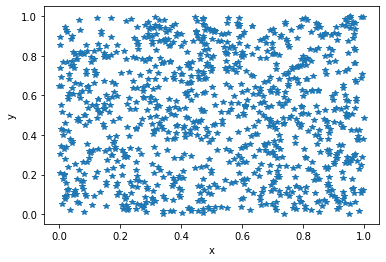

In [320]:
fig, axs = plt.subplots(1, 1)
axs.plot(x, y, '*')
axs.set_xlabel('x')
axs.set_ylabel('y')

Por lo cual, el coeficiente de correlacón de Pearson debería ser muy cercano a cero.

In [321]:
pearson(x,y)

0.0015003735650141634

Sin embargo, sin agregamos una tendencia a estos set de valores rapidamente tenemos una fuerte correlación **A PESAR** de que no estan relacionados en realidad.


In [322]:
trend = np.linspace(1, 5, 1000)
pearson(x+trend, y+trend)

0.9402776189116222

Por eeste motivo, **SIEMPRE** debemos analizar las condiciones de estacionareidad y tendencias antes de analizar una serie, y quitarle dichas tenednecia.s

### Auto-correlación

Como observamos, por construcción la correlación de una variable consigo misma es 1. Pero, si vamos aumentando un lag respecto a la observación, la correlación se difumina.

In [323]:
def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

Text(0, 0.5, 'ACF')

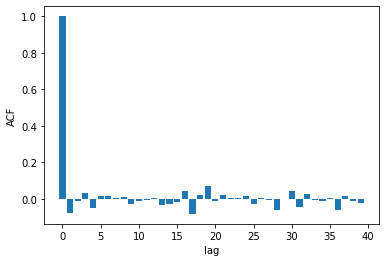

In [324]:
plt.bar(range(40), acf(x, 40))
plt.xlabel('lag')
plt.ylabel('ACF')

Entonces, podemos saber si hay autocorrelación si esta es significativamente diferente de cero. En nuestro ejemplo ficticio, podemos calcular el intervalo de confianza y descartar cualquiera que caiga dentro de este.

In [325]:
def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

In [326]:
def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determinar intervalo de confianza
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

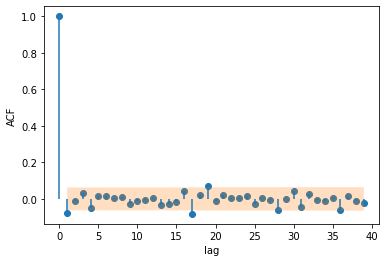

In [327]:
plot_acf(x)

Pasemos a un ejemplo real, volvamos a la serie de GDP que trabajamos al principio:

In [328]:
#Importamos desde la carpeta
GDP = pd.read_csv('data/GDP.csv', parse_dates=['DATE'])

# Nota: si no les reconoce bien la dependencia de la carpeta, pueden usar también

#GDP = pd.read_csv('https://github.com/melanieoyarzun/taller_seriestiempo_IDS/blob/8c0b9774be8d4103da3801d3069d82b4fe006461/Data/GDP.csv?raw=true', parse_dates=['DATE'])
GDP.set_index('DATE', inplace=True)


Text(0, 0.5, 'GDP ($\\$B$)')

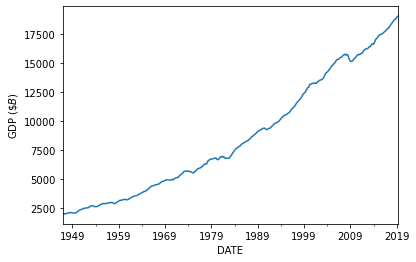

In [329]:
ax=GDP.plot(legend=False)
ax.set_ylabel(r'GDP ($\$B$)')

In [330]:
values = GDP['GDP'].values
detrended = values[1:]-values[:-1]

Como la serie tiene una fuerte tendencia, la auto-correlación parece ser significativa inluso para pargos periodos.

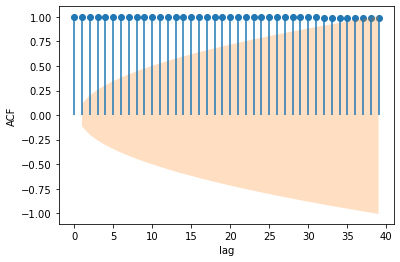

In [331]:
plot_acf(values)

Esto solo nos dice, que con mayor razón debemos sacarle la tendencia la serie.

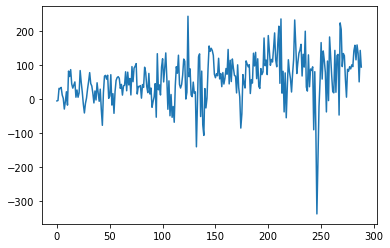

In [332]:
plt.plot(detrended)

Text(0, 0.5, 'QoQ Change ($\\$B$)')

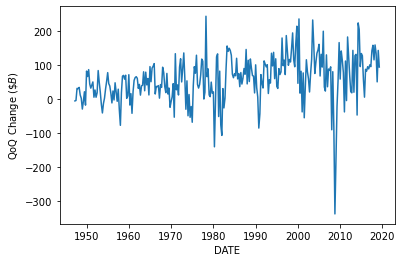

In [333]:
plt.plot(GDP.index[1:], detrended)
plt.xlabel('DATE')
plt.ylabel(r'QoQ Change ($\$B$)')

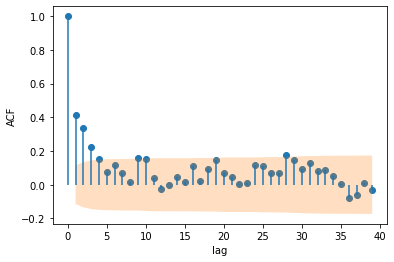

In [334]:
plot_acf(detrended)

AHora que sacamos el ruido, es mucho más informativa para modelar.

### Auto-correlación parcial

LA función de autocorrelación considera la serie completa para cada lag

In [335]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order+1):
        running.append(x[i:i+order])
        
    return np.array(running)

Podemos definir silimar la correlación parcial, solo que en cada lag trata de tener en cuenta la cantidad de correlación que ya ha sido explicada por los anteriores lags usando un modelo lineal para predecir $x_t$ e $x_{t-1}$

In [336]:
def pacf(x, lag=40):
    y = []
    
    for i in range(3, lag + 2):
        windows = rolling(x, i)

        xt = windows[:, -1] # Current values are at the end
        xt_l = windows[:, 0] # Lagged values are at 0
        inter = windows[:, 1:-1] # Intermediate values are in between 1 and -1
        
        
        lm = LinearRegression(fit_intercept=False).fit(inter, xt)
        xt_fit = lm.predict(inter)

        lm = LinearRegression(fit_intercept=False).fit(inter, xt_l)
        xt_l_fit = lm.predict(inter)

        y.append(pearson(xt - xt_fit, xt_l - xt_l_fit))
    
    # Pad the array with the two missing values
    pacf_1 = acf(x, 2)[1]
    return np.array([1, pacf_1] +  y)

In [337]:
def plot_pacf(x, alpha=0.05, lag=40):
    pacf_val = pacf(x, lag)
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('PACF')
    
    # Determine confidence interval
    ci = acf_ci(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

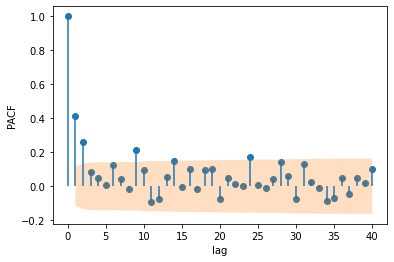

In [338]:
plot_pacf(detrended)


# Prueba estadística para estadística para tendencias estocásticas

Hasta ahora, nuestra implementación ha sino principalmente grafica. Para detectar tendencias estocásticas se suele usar el contraste de **raiz unitaria** AR

Se usa la idea de que , al menos en muestras grandes, el coeficiente de autocorrelación estará cerca de 1 si hay tendencia estocástica. Por lo cual se puede contrastar mediante una prueba de hipótesis de que hay tendencia estocástica, frente a la de que no hay ninguna tendencia.

Uno de los constrastes más comunes es el de **Dickey-Fuller**

En AR(1), se estima el paseo aleatorio y se contrasta la hipótesis  de que no hay tendencias estocasticas, vs si.

$$ \text{H}_0: \beta_1=1 \quad \text{vs} \quad \text{H}_1: \beta_1<1 \quad \text{en} \quad y_t=\beta_0+ \beta_1y_{t-1}+u_t$$

Una forma más facil de realizar este test, es transformando el modelo mediante la diferencia:

$$ \text{H}_0: \gamma=0 \quad \text{vs} \quad \text{H}_1:\gamma<0  \quad \Delta y_t= \gamma \Delta y_{t-1}+u_t$$


**Dickey-Fuller Aumentado**

Cuando no sabemos que tipo de proceso autorregresivo tienen los datos, se puede generalizar el analisis usando el Auggmented Dickey-Fuller (ADF). En este el modelo autorregresivo tiene p rezagos. 

Recordemos los datos de los viajes aereos:

In [339]:
# Cargar datos

airline = pd.read_csv('data/international-airline-passengers.csv', sep=';')
airline['Month'] = pd.to_datetime(airline['Month']+'-01')
airline.set_index('Month', inplace=True)

airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


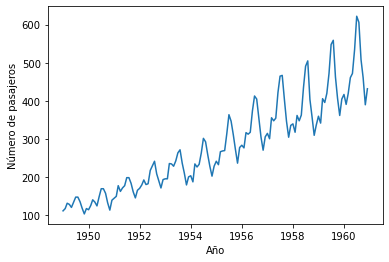

In [340]:
plt.xlabel('Año')
plt.ylabel('Número de pasajeros')
plt.plot(airline)

La inspección visual indica que hay una tendencia, revisemos los resultados de la prueba ADF:

In [341]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(airline['Passengers'])

print('ADF stat: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))



ADF stat: 0.8153688792060544
p-value: 0.9918802434376411
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


Es observable que el ADF está muy lejos del valor crítico y el p-valor es mayor que 0.05, por lual no se rechaza la existencia de raiz unitaria. Hay evidencia de que la serie es no estacionaria.

Una forma de sacar la tendencia, como vimos, es con la primera diferencia.

In [342]:
values = airline['Passengers'].values
detrended = values[1:]-values[:-1]

In [343]:
result=adfuller(detrended)

print('ADF stat: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF stat: -2.8292668241700034
p-value: 0.054213290283824954
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


Y observamos, que ahora si estamos bajo el valor crítico, por lo cual la serie es estacionaria.

# Modelando: Modelos Autorregresivos

Para modelar, entonces este tipo de datos recurriremos a una familia de mnodelos que se llaman auto-regresiovos. Esto quiere decir, que incluye rezagos como regresores para poder considerar la interdependencia temporal de los datos en el modelamiento.


## MEDIAS MOVILES (MA)


Empezamos por definir un modelo de media movil. Este es un modelo autorregresivo de "memoria corta" que se define como:

$$ x_t=\epsilon_t + \theta \epsilon_{t-1} $$

In [344]:
def MA(epsilon, theta, mean=0):
    theta = list(theta)
    N = len(epsilon)
    theta0 = np.array([1] + theta)
    theta0 = theta0[::-1] # Invert the order
    q = len(theta0)
    
    X = []
    for i in range(N-q):
        X.append(np.dot(theta0, epsilon[i:i+q])+mean)
    
    return np.array(X)

Esta función simplemente multiplica el coeficiente $\theta$ con las variables estocasticas. 
Generamos algunos ejemplos y los visualizamos.

In [345]:
N = 500
thetas = []
X_MA = []
q_max = 8

epsilon = np.random.normal(size=N)

for q in range(1, q_max+1, 2):
    thetas.append(np.random.random(q))
    X_MA.append(MA(epsilon, thetas[-1]))

Y las visualizamos lado a lado.

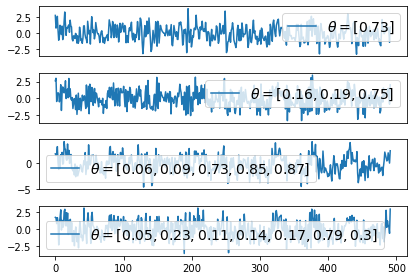

In [346]:
fig, axs = plt.subplots(4, 1)

for i in range(q_max//2):
    axs[i].plot(X_MA[i])
    axs[i].legend([r'$\theta=\left[%s\right]$' % ", ".join(thetas[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

Ahora deseamos calcular el grafico de autocorrelación, asi que re introducimos las funciones que ya definimos

In [347]:
def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determine confidence interval
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

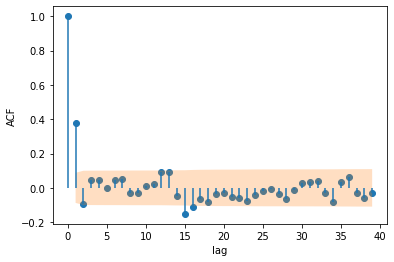

In [348]:
plot_acf(X_MA[0])

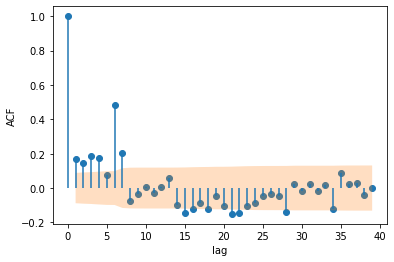

In [349]:
plot_acf(X_MA[-1])

Es observable que el número de lags significantes, pareciera ser elmismo que en el modelo MA.

## Auto regresivo (AR)

Ahora definimos el modelo autorregresivo. La función es similar a la MA pero usa posiciones en lugar de los valores estocásticos brutos
Su ecuación es:

$$ x_t=\epsilon_t + \theta x_{t-1} $$


In [350]:
def AR(epsilon, phi, drift=0):
    phi = list(phi)
    N = len(epsilon)

    phi0 = np.array([1] + phi)
    phi0 = phi0[::-1] # invertir el orden
    p = len(phi0)
    
    X = epsilon.copy()

    for i in range(p, N):
        X[i-1] = np.dot(X[i-p:i], phi0) + drift
        
    return np.array(X)

Generamos algunos ejemplos y los vizualizamos

In [351]:
N = 500
phis = []
X_AR = []
p_max = 8

epsilon = np.random.normal(size=N)

for p in range(1, p_max+1, 2):
    phis.append(np.random.normal(0, .2, p))
    X_AR.append(AR(epsilon, phis[-1]))

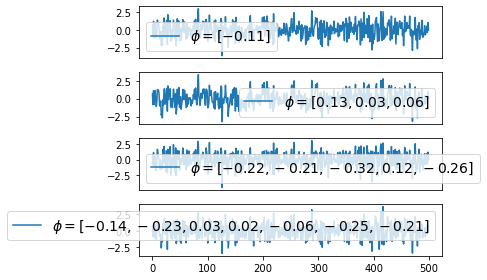

In [352]:
fig, axs = plt.subplots(4, 1)

for i in range(p_max//2):
    axs[i].plot(X_AR[i])
    axs[i].legend([r'$\phi=\left[%s\right]$' % ", ".join(phis[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

Y agregamos las funciones requeridas para la Auto-correlación parcial.

In [353]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order):
        running.append(x[i:i+order])
        
    return np.array(running)

In [354]:
def pacf(x, lag=40):
    y = []
    
    for i in range(3, lag + 2):
        windows = rolling(x.flatten(), i)

        xt = windows[:, -1] # Current values are at the end
        xt_l = windows[:, 0] # Lagged values are at 0
        inter = windows[:, 1:-1] # Intermediate values are in between 1 and -1

        lm = LinearRegression(fit_intercept=False).fit(inter, xt)
        xt_fit = lm.predict(inter)

        lm = LinearRegression(fit_intercept=False).fit(inter, xt_l)
        xt_l_fit = lm.predict(inter)

        y.append(pearson(xt - xt_fit, xt_l - xt_l_fit))
    
    # Pad the array with the two missing values
    pacf_1 = acf(x, 2)[1]
    return np.array([1, pacf_1] +  y)

In [355]:
def plot_pacf(x, alpha=0.05, lag=40):
    pacf_val = pacf(x, lag)
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('PACF')
    
    # Determine confidence interval
    ci = acf_ci(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

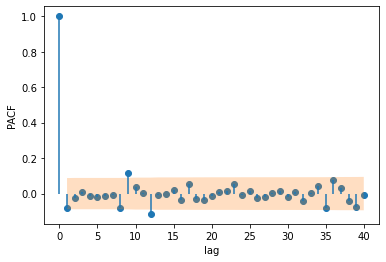

In [356]:
plot_pacf(X_AR[0])

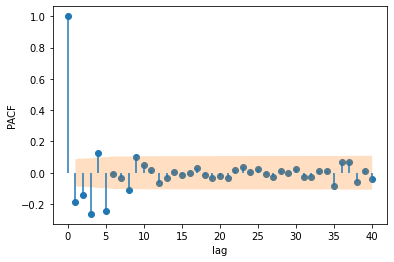

In [357]:
plot_pacf(X_AR[-2])

# ARIMA

ARIMA que significa Autoregressive Integrated Moving-Average, es un modelamiento de serie de tiempo que combina modelos auto regresivos (AR) y medias moviles (MA), con la opcion de incluir raices unitarias.

Estos modelos tienen 3 parámetros: p, que son cuantos autorregresores tiene el modelo AR, q que indica cuantos parametros tiene la media movil y 

FInalmente, la combinación de ambos modelamientos es 
$$ x_t=\epsilon_t + \phi x_{t-1} + \theta \epsilon_{t-1} $$

Si el modelo de los datos es estacionario, entonces no es necesario diferenciar y se usa d=0. Sino, requerimos diferenciar con d>1. 

Adicionalmente existe la clase SARIMA, o Seasonal- ARIMA que le agrega coeficientes que controlan por la estacionalidad.

In [358]:
def differentiate(values, d=1):
    # First value is required so that we can recover the original values with np.cumsum
    x = np.concatenate([[values[0]], values[1:]-values[:-1]])

    if d == 1:
        return x
    else:    
        return differentiate(x, d - 1)

In [359]:
def integrate(values, d=1):
    x = np.cumsum(values)
    
    if d == 1:
        return x
    else:
        
        return integrate(x, d-1)

La clase de ARIMA es una variante de la definida en [https://www.ritchievink.com/blog/2018/09/26/algorithm-breakdown-ar-ma-and-arima-models](https://www.ritchievink.com/blog/2018/09/26/algorithm-breakdown-ar-ma-and-arima-models).

In [360]:
class ARIMA(LinearRegression):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = differentiate(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features = rolling(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = rolling(np.r_[np.zeros(self.p), x], self.p)
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = integrate(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

Tambien se puede importar directamente desde statsmodels donde debemos proveer p, d y q.

In [361]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

Estimemos el modelo con p=1 (coeficientes AR), d=1 (orden de diferenciacion), q=1 (coeficientes MA). Notar que d realiza la diferenciación y le saca la tendencia a la serie, segun los resultados del ADF.

In [362]:
modelo1_GDP = ARIMA(GDP, order=(1,1,1))
modelo1_fit=modelo1_GDP.fit()
modelo1_fit.summary()

/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1607.431
Date:                Sun, 12 Dec 2021   AIC                           3220.861
Time:                        21:07:07   BIC                           3231.861
Sample:                    01-01-1947   HQIC                          3225.269
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9416      0.024     38.775      0.000       0.894       0.989
ma.L1         -0.5952      0.050    -11.800      0.000      -0.694      -0.496
sigma2      3955.1632    221.551     17.852      0.000    3520.931    4389.395
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               135.32
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Adicionalmente, está la estimacion con autoarima, que elije automaticamente p, q y d (minimizando AIC).

In [363]:
#!pip install pmdarima
from pmdarima.arima import auto_arima

In [364]:
modelo2_GDP = auto_arima(GDP, start_P=0, start_Q=0)
modelo2_GDP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  290
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1592.341
Date:                Sun, 12 Dec 2021   AIC                           3192.681
Time:                        21:07:09   BIC                           3207.333
Sample:                             0   HQIC                          3198.553
                                - 290                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2925      0.046      6.353      0.000       0.202       0.383
ar.L2          0.1677      0.051      3.297      0.001       0.068       0.267
ma.L1         -0.9765      0.014    -68.045      0.000      -1.005      -0.948
sigma2      3688.7172    195.218     18.895      0.000    3306.098    4071.337
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               367.68
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               4.81   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Podemos ver que el algoritmo eligio un (2,2,1) para (p,d,q). 

# Eligiendo un modelo

Generalmente, la eleccion de modelos y la longitud de sus rezagos se hace mediante AIC o BIC.

AIC (Akaike Information Criterion)
$$ BIC(p) = log\left( \frac{SSR(p)}{T} \right) + (p + 1) \frac{log(T)}{T}$$

 * Menor AIC indica un mejor modelo
  
BIC (Bayesian Information Criterion)

$$ AIC(p) = log\left( \frac{SSR(p)}{T} \right) + (p + 1) \frac{2}{T}$$

  * Muy similar a AIC
  * Menor BIC indicates a better model

AIC vs BIC
La diferencia entre ambos, es como penalizan la complejidad del modelo.
BIC favorece modelos más simples que AIC.
Generalmente, AIC se prefiere para modelos predictivos y BIC para explicativos.


## Ejemplo

En nuestro ejemplo anterior, teniamos estimados dos modelos por ARIMA: modelo 1 (1,0,1) y modelo 2(2,2,1). SI tuvieramos que elegir uno de estos, deberiamos compara el AIC y/o BIC de ambos.

In [365]:
modelo1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1607.431
Date:                Sun, 12 Dec 2021   AIC                           3220.861
Time:                        21:07:09   BIC                           3231.861
Sample:                    01-01-1947   HQIC                          3225.269
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9416      0.024     38.775      0.000       0.894       0.989
ma.L1         -0.5952      0.050    -11.800      0.000      -0.694      -0.496
sigma2      3955.1632    221.551     17.852      0.000    3520.931    4389.395
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               135.32
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [366]:
modelo2_GDP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  290
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1592.341
Date:                Sun, 12 Dec 2021   AIC                           3192.681
Time:                        21:07:09   BIC                           3207.333
Sample:                             0   HQIC                          3198.553
                                - 290                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2925      0.046      6.353      0.000       0.202       0.383
ar.L2          0.1677      0.051      3.297      0.001       0.068       0.267
ma.L1         -0.9765      0.014    -68.045      0.000      -1.005      -0.948
sigma2      3688.7172    195.218     18.895      0.000    3306.098    4071.337
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               367.68
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               4.81   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Podemos ver que el modelo 2, elegido por AUTOARIMA, es el de menor AIC y BIC.

# Modelamiento y predicción

Con los elementos que hemos revisado, vamos a realizar un modelamiento con el 80% de la muestra y revisar su ajuste con el 20% restante. Luego con ese modelo, vamos a generar una predicción fuera de la muestra.

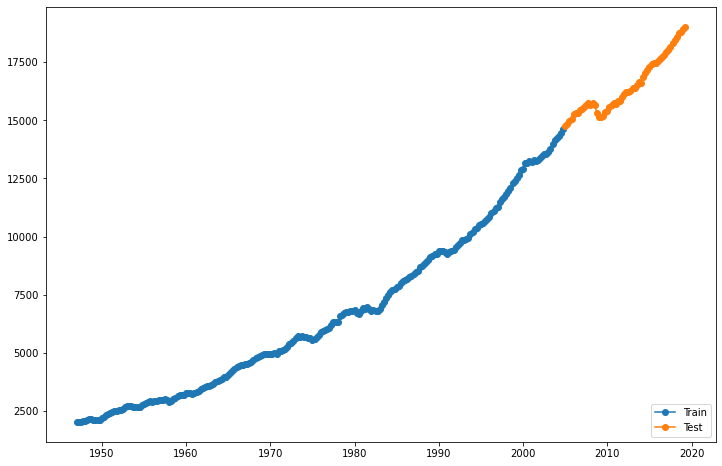

In [367]:
# Proporción entrenamiento y chequeo de ajuste

train_size = 0.8
split_idx = round(len(GDP)* train_size)
split_idx

# Split
train = GDP.iloc[:split_idx]
test = GDP.iloc[split_idx:]

# Visualizamos la division
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
plt.legend(loc="lower right")

Ajustamos el modelo a los datos de entrenamiento.

In [368]:
model=auto_arima(train, start_p=0, start_q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1237.743
Date:                Sun, 12 Dec 2021   AIC                           2483.486
Time:                        21:07:11   BIC                           2497.238
Sample:                             0   HQIC                          2489.033
                                - 232                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2536      0.066      3.818      0.000       0.123       0.384
ar.L2          0.1840      0.053      3.492      0.000       0.081       0.287
ma.L1         -0.9661      0.019    -51.604      0.000      -1.003      -0.929
sigma2      2745.0830    194.607     14.106      0.000    2363.660    3126.506
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.73   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La opcion summary nos provee toda la información de nuestro modelo. También podemos revisar lo graficos del modelo.

/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


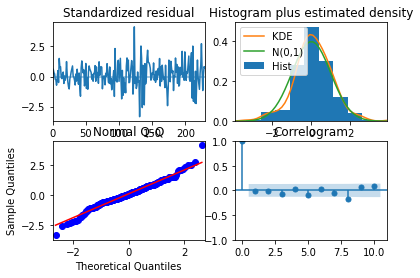

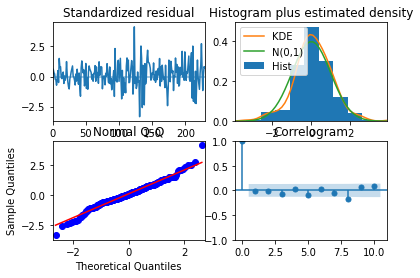

In [369]:
model.plot_diagnostics()

## Valores Ajustados- Predichos 

Usando el modelo que obtuvimos con los datos de entrenamientom vamos a revisar su ajuste prediciendo los datos de prueba.
No confundir, valores ajustados con proyección fuera de la muestra. La idea es comrbobar que tan bien el modelo predice los datos ya observados.

In [370]:
#total de valores a predecir en muestra de prueba
len(test)

58

In [371]:
prediccion = pd.DataFrame( model.predict(n_periods=len(test)), index=test.index )
prediccion.columns = ['predicted GDP']
prediccion.head()

,predicted GDP
DATE,
2005-01-01,14725.301335
2005-04-01,14834.990134
2005-07-01,14937.802099
2005-10-01,15037.814697
2006-01-01,15135.852035


Revisemos como se compara la predicción con los datos reales

<function matplotlib.pyplot.show(close=None, block=None)>

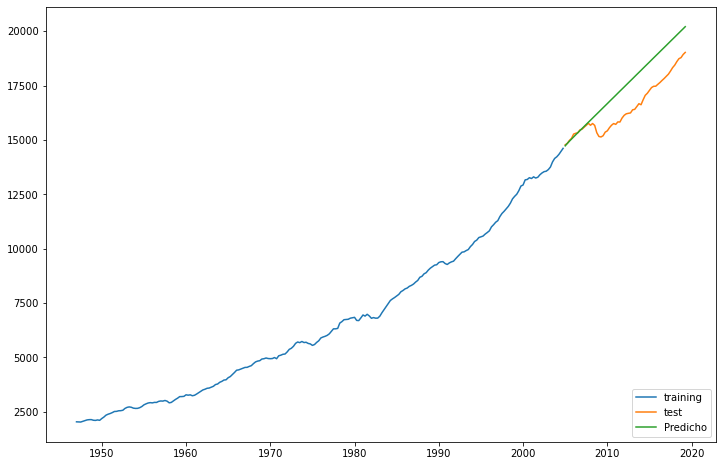

In [372]:
plt.subplots(figsize=(12,8))
plt.plot(train, label="training")
plt.plot(test, label="test")
plt.plot(prediccion, label="Predicho")
plt.legend(loc="lower right")
plt.show

Podemos ver que el modelo no ajusta tan bien, porque está incluido el dato del 2009, donde ocurre la crisis SubPrime. Veamos que ocurre si ampliamos el rango de entrenamiento para que lo incluya en el modelo y la predicción se haga sobre un menor rango.

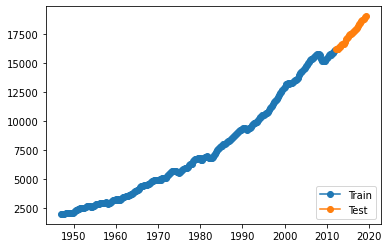

In [373]:
# Proporción entrenamiento y chequeo de ajuste

train_size = 0.9
split_idx = round(len(GDP)* train_size)
split_idx

# Split
train = GDP.iloc[:split_idx]
test = GDP.iloc[split_idx:]

# Visualizamos la division
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
plt.legend(loc="lower right")

In [374]:
model=auto_arima(train, start_p=0, start_q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1429.762
Date:                Sun, 12 Dec 2021   AIC                           2867.525
Time:                        21:07:14   BIC                           2881.752
Sample:                             0   HQIC                          2873.245
                                - 261                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3138      0.052      6.026      0.000       0.212       0.416
ar.L2          0.1815      0.053      3.409      0.001       0.077       0.286
ma.L1         -0.9786      0.014    -71.619      0.000      -1.005      -0.952
sigma2      3622.7629    208.829     17.348      0.000    3213.466    4032.060
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               385.11
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.61   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [375]:
prediccion = pd.DataFrame( model.predict(n_periods=len(test)), index=test.index )
prediccion.columns = ['predicted GDP']
prediccion.head()

,predicted GDP
DATE,
2012-04-01,16238.065463
2012-07-01,16330.940199
2012-10-01,16415.841728
2013-01-01,16495.378868
2013-04-01,16571.785764


<function matplotlib.pyplot.show(close=None, block=None)>

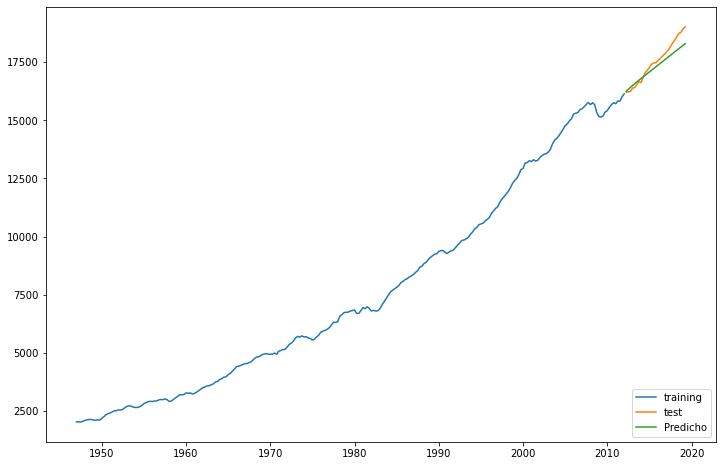

In [376]:
plt.subplots(figsize=(12,8))
plt.plot(train, label="training")
plt.plot(test, label="test")
plt.plot(prediccion, label="Predicho")
plt.legend(loc="lower right")
plt.show

Si nos fijamos, ahora la predicción es mucho mejor. Podemos seguir refinando la elección de tiempo, especialmente al considerar la posibilidad de quiebres estructurales.



## Predicciones fuera de muestra

Los modelos ARIMA son muy buenos creando predicciones fuera de muestra en un paso, es decir, el siguiente periodo después de los datos.

In [377]:
model = ARIMA(GDP, order=(2,2,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  290
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1592.341
Date:                Sun, 12 Dec 2021   AIC                           3192.681
Time:                        21:07:15   BIC                           3207.333
Sample:                    01-01-1947   HQIC                          3198.553
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2925      0.046      6.353      0.000       0.202       0.383
ar.L2          0.1677      0.051      3.297      0.001       0.068       0.267
ma.L1         -0.9765      0.014    -68.045      0.0

/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/melanie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [378]:
results.forecast(steps=1)

2019-07-01    19120.265611
Freq: QS-OCT, dtype: float64

También esta lo que se llama *multi-step out of sample forecast* o predicción fuera de la muestra en multiples pasos. EN esta se va estimando paso a paso un periodo adicional, incluyendolo en en analisis, actualizando el modelo y re-estimando. Por ejemplo, estimemos para los siguientes 20 periodos.

In [379]:
pred=results.get_forecast(steps=20, dynamic=False )
pred_ci= pred.conf_int()

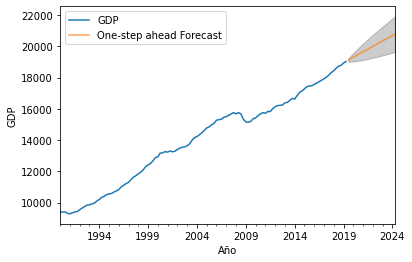

In [380]:
ax = GDP['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Año')
ax.set_ylabel('GDP')
plt.legend()
plt.show()

Finalmente, vamos a agergarle estos a un nuevo dataframe que incluya la predicción.

In [381]:
from pandas.tseries.offsets import DateOffset

future_dates=[GDP.index[-1]+ DateOffset(years=x)for x in range(-2,10)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=GDP.columns)

future_datest_df

,GDP
2018-04-01,NaN
2019-04-01,NaN
2020-04-01,NaN
2021-04-01,NaN
2022-04-01,NaN
2023-04-01,NaN
2024-04-01,NaN
2025-04-01,NaN
2026-04-01,NaN
2027-04-01,NaN


In [382]:
forecast_df=pd.DataFrame(pred.predicted_mean)

NaN=np.nan

forecast_df['GDP']=NaN
forecast_df

,predicted_mean,GDP
2019-07-01,19120.265611,NaN
2019-10-01,19211.547974,NaN
2020-01-01,19301.388593,NaN
2020-04-01,19389.613058,NaN
2020-07-01,19477.123069,NaN
2020-10-01,19564.153107,NaN
2021-01-01,19650.922959,NaN
2021-04-01,19737.536226,NaN
2021-07-01,19824.060065,NaN
2021-10-01,19910.531491,NaN


In [383]:
GDP_forecast= pd.DataFrame(GDP['GDP'])
GDP_forecast['predicted_mean']=NaN
GDP_forecast

,GDP,predicted_mean
DATE,,
1947-01-01,2033.061,NaN
1947-04-01,2027.639,NaN
1947-07-01,2023.452,NaN
1947-10-01,2055.103,NaN
1948-01-01,2086.017,NaN
...,...,...
2018-04-01,18598.135,NaN
2018-07-01,18732.720,NaN
2018-10-01,18783.548,NaN


In [384]:
GDP_forecast=pd.concat([GDP_forecast,forecast_df])
GDP_forecast

,GDP,predicted_mean
1947-01-01,2033.061,NaN
1947-04-01,2027.639,NaN
1947-07-01,2023.452,NaN
1947-10-01,2055.103,NaN
1948-01-01,2086.017,NaN
...,...,...
2023-04-01,NaN,20429.021991
2023-07-01,NaN,20515.422582
2023-10-01,NaN,20601.822493
2024-01-01,NaN,20688.222010


<AxesSubplot:>

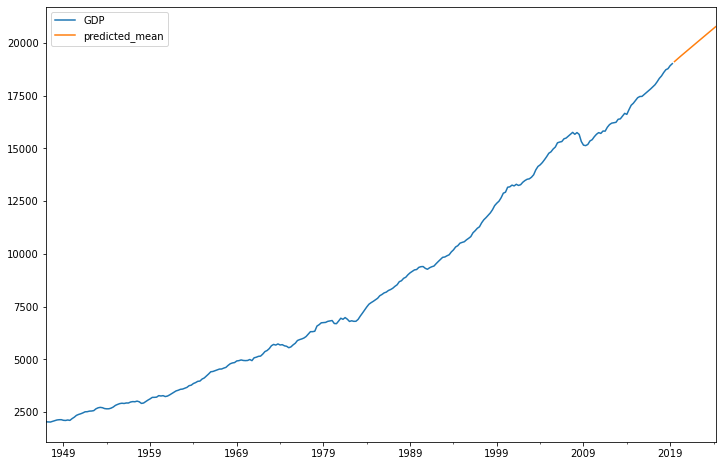

In [385]:
GDP_forecast[['GDP', 'predicted_mean']].plot(figsize=(12, 8))

Graficamente:

# Resumen general:

Hemos visto varios elementos de estacionareidad y autocorrelación, reunamoslo en un análisis compacto.

1. Chequeamos la estacionareidad usando media y varianza movil y el test de Dickey-Fuller aumentado.

Para esto creamos una función, que depende de una ventana para los análisis (w) y con esta, revisamos la serie de tiempo (ts)
   


In [386]:
def stationarity_check(ts, w):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=w, center=False).mean()
    roll_std = ts.rolling(window=w, center=False).std()

    # Perform the Dickey Fuller test
    dftest = adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



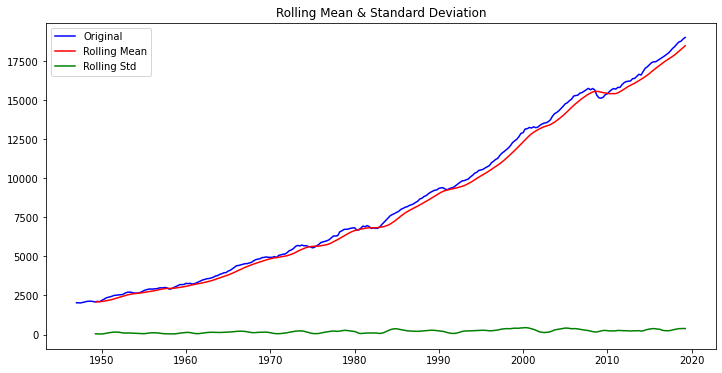


Results of Dickey-Fuller Test: 

Test Statistic                   2.962229
p-value                          1.000000
#Lags Used                      12.000000
Number of Observations Used    277.000000
Critical Value (1%)             -3.454180
Critical Value (5%)             -2.872031
Critical Value (10%)            -2.572360
dtype: float64


In [387]:
#ejemplo con GPD y w=10

stationarity_check(GDP, w=10)


Claramente la serie NO es estacionaria. Ahora necesitamos sacarle las tendencias para proceder

2. Aplicamos una descomposición con seasonal_dceomposition() desde statsmodels.tsa.seasonal para visualizar las tendencias, la estacionalidad y residuos.


In [388]:
from statsmodels.tsa.seasonal import seasonal_decompose


def decomposition_plot(ts):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(np.log(ts))
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()


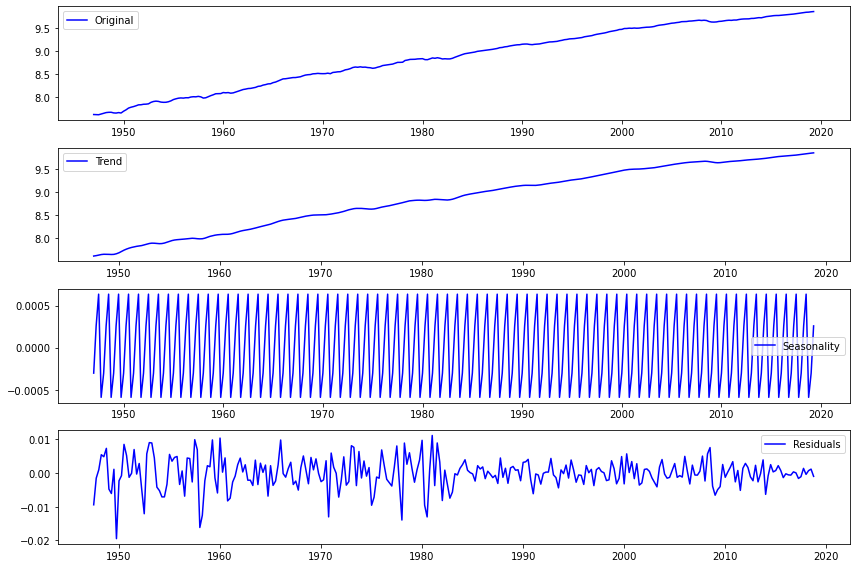

In [389]:
decomposition_plot(GDP)

2. Realizamos una diferenciación para eliminar las tendencias. 

In [390]:
GDP['1 diff']= GDP['GDP']-GDP['GDP'].shift(1)
GDP

,GDP,1 diff
DATE,,
1947-01-01,2033.061,NaN
1947-04-01,2027.639,-5.422
1947-07-01,2023.452,-4.187
1947-10-01,2055.103,31.651
1948-01-01,2086.017,30.914
...,...,...
2018-04-01,18598.135,159.881
2018-07-01,18732.720,134.585
2018-10-01,18783.548,50.828


In [391]:
A=pd.DataFrame(GDP['1 diff'])
A=A.dropna() # ya que al diferenciar se pierden observaciones

Chequeamos si la serie diferenciada elimina la tendencia. Sino, volvemos a diferenciar.

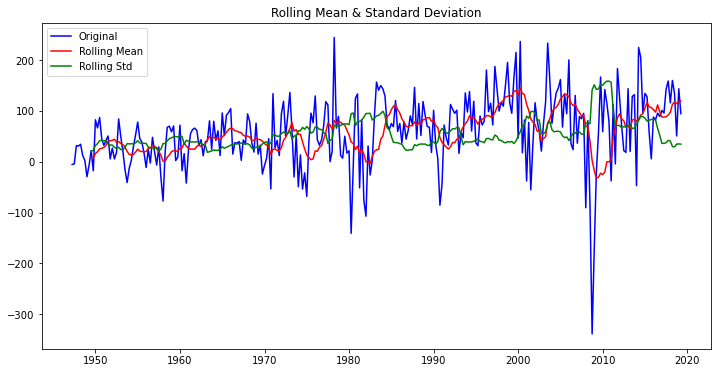


Results of Dickey-Fuller Test: 

Test Statistic                  -4.109942
p-value                          0.000933
#Lags Used                      11.000000
Number of Observations Used    277.000000
Critical Value (1%)             -3.454180
Critical Value (5%)             -2.872031
Critical Value (10%)            -2.572360
dtype: float64


In [392]:
stationarity_check(A, 10)

3. Graficamos la autocorrelacion total y parcial, para proveer informacion sobre posibles (p,d,q) para modelar.

In [393]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [405]:
def plot_acf_pacf(ts, figsize=(10,8),lags=30):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    # Plot ts
    ts.plot(ax=ax[0])
    
    # Plot acf, pavf
    plot_acf(ts.dropna(), ax=ax[1], lags=lags)
    plot_pacf(ts.dropna(), ax=ax[2], lags=lags) 
    fig.tight_layout()
    
   

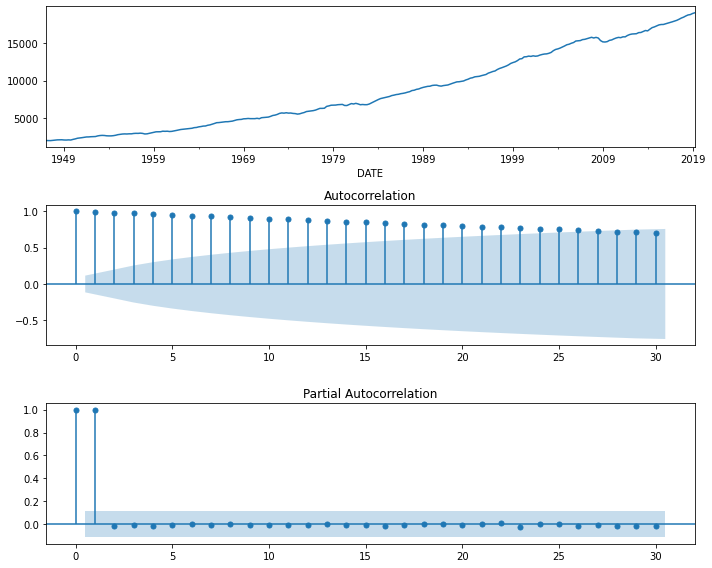

In [406]:
 plot_acf_pacf(GDP['GDP'], figsize=(10,8),lags=30)

4. Proceder con la modelacion, ya sea usando ARIMA o auto_arima. Y en base a este realizar comprobaciones de ajuste o predicciones.

In [186]:
model=auto_arima(GDP['GDP'], start_p=0, start_q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  290
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1592.341
Date:                Sun, 12 Dec 2021   AIC                           3192.681
Time:                        20:53:45   BIC                           3207.333
Sample:                             0   HQIC                          3198.553
                                - 290                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2925      0.046      6.353      0.000       0.202       0.383
ar.L2          0.1677      0.051      3.297      0.001       0.068       0.267
ma.L1         -0.9765      0.014    -68.045      0.000      -1.005      -0.948
sigma2      3688.7172    195.218     18.895      0.000    3306.098    4071.337
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               367.68
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               4.81   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Bloque 2: Aplicaicón

Considere el mecanismo para extraer datos de la sección anterior. Elija un país a analozar y realice las siguientes operaciones.


1. Calule $y_t=ln(GDP_t)$, que es el logaritmo del PIB real y $\Delta y_t$ como la tasa de crecimiento anual del PIB para el periodo. 
2. Estime la media de $\Delta y_t$
3. Estme la desviación estandar de $\Delta y_t$
4. Estime las cuatro primeras autocorrelaciones de $\Delta y_t$, ¿cuales son las unidades de medidas de estas autocorrelaciones?
5. Estime un modelo AR(1) para $\Delta y_t$. ¿Cual es el coeficiente para el vector autorregresivo? ¿Es estadisticamente significativo? Construya un intervalo de confianza para el estimador poblacional.
6. Estime un modelo AR(2) para $\Delta y_t$. ¿Cual es el coeficiente para el vector autorregresivo? ¿Es estadisticamente significativo? Construya un intervalo de confianza para el estimador poblacional.
7. Estime un modelo AR(3) y AR(4) para $\Delta y_t$. Utilice el criterio BIC y AIC para elegir el numero de rezagos.
8. Utilice un estadístico de Dickey- FUlller aumentado para contrastar la presencia de raiz unitaria. Como alternativa, suponga que Y es estacionaria al rededor de una detendecia determinística.
9.  Identifique la tendencia y posible estacionalidad y haga la descomposción grafica.
10. ¿Podría existir un quiebre estructural en 2009? ¿Cómo lo probaría?